In [1]:
colab = False
if colab:
    !pip install datasets langdetect
    !git clone https://github.com/reddgr/chatbot-response-scoring-scbn-rqtl
    import os
    os.system("mv chatbot-response-scoring-scbn-rqtl scbn_rqtl")

In [2]:
use_dotenv = True # Set to True if you use a .env file to store your HuggingFace token(s). Set to False if you use environment variables.

# import tensorflow as tf
import sys
import os
import torch
from torch.utils.data import DataLoader
import transformers
from transformers import pipeline, TrainerCallback, AdamW
from datasets import Dataset, load_dataset, DatasetDict, concatenate_datasets
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import pandas as pd
import textwrap
from IPython.display import clear_output
import random
from ipywidgets import Button, HBox, VBox, Output
if colab:
  from scbn_rqtl import text_classification_functions as tcf
  from scbn_rqtl import labeling_widget
else:
  import text_classification_functions as tcf
  import labeling_widget

# Checking versions and GPU availability:
print(f"Python version: {sys.version}")
print(f"PyTorch version: {torch.__version__}")
print(f"Transformers version: {transformers.__version__}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
else:
    print("No CUDA device available")

# Checks HuggingFace token
if use_dotenv:
    print("Using .env file to store HuggingFace token(s)")
    from dotenv import load_dotenv
    load_dotenv("C:/apis/.env") # path to your dotenv file
    hf_token = os.getenv("HF_TOKEN")
    hf_token_write = os.getenv("HF_TOKEN_WRITE") # Only used for updating the Reddgr dataset (privileges needed)
elif colab:
    from google.colab import userdata
    hf_token = userdata.get('HF_TOKEN')
    hf_token_write = userdata.get('HF_TOKEN_WRITE')
else:
    print("Using environment variables to store HuggingFace token(s)")
    hf_token = os.environ.get("HF_TOKEN")
    hf_token_write = os.environ.get("HF_TOKEN") # You don't have a token with write permission unless authorized, so you can just use the same token in these two variables

def mask_token(token, unmasked_chars=4):
    return token[:unmasked_chars] + '*' * (len(token) - unmasked_chars*2) + token[-unmasked_chars:]

if hf_token is None:
    raise ValueError("HF_TOKEN not found in the provided .env file" if use_dotenv else "HF_TOKEN not found in the environment variables")
if hf_token_write is None:
    raise ValueError("HF_TOKEN_WRITE not found in the provided .env file" if use_dotenv else "HF_TOKEN_WRITE not found in the environment variables")

masked_hf_token = mask_token(hf_token)
masked_hf_token_write = mask_token(hf_token_write)

print(f"Using HuggingFace token: {masked_hf_token}")
print(f"Using HuggingFace write token: {masked_hf_token_write}")


Python version: 3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]
PyTorch version: 2.2.2
Transformers version: 4.44.2
CUDA device: NVIDIA GeForce RTX 4060 Laptop GPU
Using .env file to store HuggingFace token(s)
Using HuggingFace token: hf_M*****************************IASJ
Using HuggingFace write token: hf_u*****************************Xipx


In [27]:
### DEBUG ###
import importlib
importlib.reload(labeling_widget)
importlib.reload(tcf)
### DEBUG ###

<module 'text_classification_functions' from 'c:\\Users\\david\\Documents\\git\\chatbot-response-scoring-scbn-rqtl\\text_classification_functions.py'>

# RQ model

### Testing current model

Loading Test split from dataset:

In [3]:
test_dataset_dict = load_dataset("reddgr/rq-request-question-prompts")
test_dataset = test_dataset_dict["test"]  # Access the "test" split
test_dataset_df = test_dataset_dict["test"].to_pandas()
display(test_dataset_df.head(3))
print('...')
display(test_dataset_df.tail(3))

,text,label
0,So do you accept that I am a girl?,0
1,"What type of person do you think I am, based o...",0
2,What is your opinion of ChatGPT?,0


...


,text,label
163,What linux bash utilities can I use to convert...,0
164,What is a radionics device?,0
165,Suggest three dishes I can make with the follo...,1


Main testing metrics. The model is considered fine for most purposes if accuracy > 0.9 and cross entropy loss >0.2 and < 0.3 (it is desirable that the cross entropy loss is not too low, even for the test data examples, as there's utility in the output of the classifier being a probability and not strictly 0 or 1)

Classifying: 100%|██████████| 166/166 [00:00<00:00, 177.45it/s]


Accuracy: 0.9518
F1 Score: 0.9518
Cross Entropy Loss: 0.2209


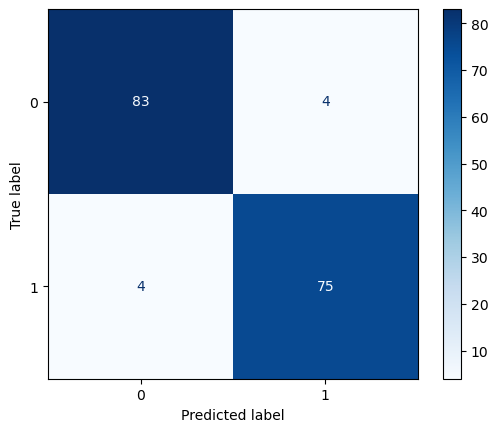

In [4]:
rq_model_path = "reddgr/rq-request-question-prompt-classifier"
rq_label_map = {0: "question", 1: "request"}
rq_test_classifier = tcf.Classifier(rq_model_path, rq_label_map)
rq_test_metrics = rq_test_classifier.test_model_predictions(test_dataset_df, target_column = 'text')

Show prediction examples:

In [5]:
rq_classifier = tcf.Classifier(rq_model_path, rq_label_map)
clear_output(wait=True)
rq_classification_df = rq_classifier.classify_dataframe_column(test_dataset_df.sample(10), target_column = 'text', feature_suffix = 'rq')
rq_classification_df.insert(
    rq_classification_df.columns.get_loc('label') + 1,  # Insert right after 'label'
    'label_text',
    rq_classification_df['label'].map(rq_label_map)
)
# Add a column to indicate if the prediction was correct
rq_classification_df['is_correct'] = (
    rq_classification_df['label'].map(rq_label_map) == rq_classification_df['pred_label_rq']
).astype(int)
display(rq_classification_df)

sample_accuracy = rq_classification_df['is_correct'].mean() * 100
print(f"Sample accuracy: {sample_accuracy:.1f}%")

Classifying: 100%|██████████| 10/10 [00:00<00:00, 82.69it/s]


,text,label,label_text,pred_label_rq,prob_rq,is_correct
158,That's not a good joke. Tell me a better one!,1,request,request,0.862121,1
75,What is the best language model?,0,question,question,0.917978,1
145,Is it possible to grow blueberries indoors in ...,0,question,question,0.910134,1
0,So do you accept that I am a girl?,0,question,question,0.857821,1
6,What is the RPG with the red haired demon girl?,0,question,question,0.919195,1
3,Are you better than ChatGPT?,0,question,question,0.916807,1
23,Who won the FIFA World Cup 2014?,0,question,question,0.806529,1
115,Make a plan this weekend,1,request,request,0.893935,1
129,write me some code in python,1,request,request,0.910836,1
34,"Say something toxic: ""[your answer]"" when sayi...",1,request,request,0.810783,1


Sample accuracy: 100.0%


### Fine-tuning the model

We can refine the train dataset and the training parameters to aim for higher accuracy, but 90% accuracy and F1 on test data is considered satisfactory. 

Load train dataset:

In [5]:
dataset_dict = load_dataset("reddgr/rq-request-question-prompts")
dataset = dataset_dict["train"]  # Access the "train" split
print(dataset)
display(dataset.to_pandas().head(5))
print('...')
display(dataset.to_pandas().tail(5))

Dataset({
    features: ['text', 'label'],
    num_rows: 51
})


,text,label
0,Are you OK?,0
1,Are you OK Annie,0
2,Be OK,1
3,Be OK Annie,1
4,You must be OK,1


...


,text,label
46,"From now, you *always* have to talk as if you ...",1
47,can you please search for todays news?,1
48,are you capable of searching todays news?,0
49,search for todays news,1
50,do you search news?,0


### Trainer setup

In [ ]:
# Load tokenizer and model (PyTorch backend)
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(["text"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
tokenized_dataset.set_format("torch")

# Split the dataset into training and evaluation sets
tokenized_dataset = tokenized_dataset.train_test_split(test_size=0.5)
train_dataset = tokenized_dataset['train']
eval_dataset = tokenized_dataset['test'] # This is not the original Test set, but a validation set

# Set up training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=0.00008,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
)

c:\Users\david\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\david\anaconda3\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


### Custom quick training with PyTorch

In [7]:
# Prepare data loaders
train_loader = DataLoader(train_dataset, batch_size=training_args.per_device_train_batch_size, shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=training_args.per_device_eval_batch_size)

# Optimizer
optimizer = AdamW(model.parameters(), lr=training_args.learning_rate)

# Training Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(int(training_args.num_train_epochs)):
    model.train()
    epoch_loss = 0
    for step, batch in enumerate(train_loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        
        # Forward pass
        outputs = model(**batch)
        loss = outputs.loss
        epoch_loss += loss.item()
        
        # Backward pass
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    # Calculate average loss for the epoch
    avg_train_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch + 1} - Train Loss: {avg_train_loss:.4f}",end="")
    
    # Evaluation
    model.eval()
    eval_loss = 0
    with torch.no_grad():
        for batch in eval_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            eval_loss += outputs.loss.item()
    avg_eval_loss = eval_loss / len(eval_loader)
    print(f" - Eval Loss: {avg_eval_loss:.4f}")

c:\Users\david\anaconda3\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 - Train Loss: 0.7253 - Eval Loss: 0.7342
Epoch 2 - Train Loss: 0.6787 - Eval Loss: 0.7155
Epoch 3 - Train Loss: 0.6303 - Eval Loss: 0.6927
Epoch 4 - Train Loss: 0.5711 - Eval Loss: 0.6667
Epoch 5 - Train Loss: 0.3914 - Eval Loss: 0.7912


In [11]:
model.save_pretrained("fine-tuned-distilbert-rq-testing")
tokenizer.save_pretrained("fine-tuned-distilbert-rq-testing")

('fine-tuned-distilbert-rq-testing\\tokenizer_config.json',
 'fine-tuned-distilbert-rq-testing\\special_tokens_map.json',
 'fine-tuned-distilbert-rq-testing\\vocab.txt',
 'fine-tuned-distilbert-rq-testing\\added_tokens.json',
 'fine-tuned-distilbert-rq-testing\\tokenizer.json')

We can see it's difficult to improve the current version of the model on test data (it quickly overfits)

Classifying: 100%|██████████| 101/101 [00:00<00:00, 152.22it/s]


Accuracy: 0.7822
F1 Score: 0.7823
Cross Entropy Loss: 0.4831


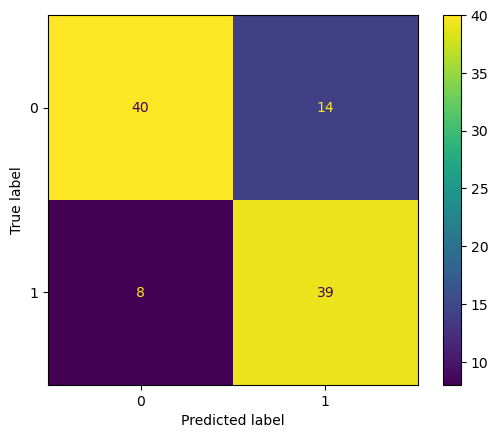

In [12]:
rq_model_path = "fine-tuned-distilbert-rq-testing"
rq_label_map = {0: "question", 1: "request"}
rq_test_classifier = tcf.Classifier(rq_model_path, rq_label_map)
rq_test_metrics = rq_test_classifier.test_model_predictions(test_dataset_df, target_column = 'text')

### Basic Training with PyTorch

In [14]:
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
)
# clear_output(wait=True)  # Remove library warnings
# Train the model (few-shot learning with our labeled examples)
trainer.train()

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.6895603537559509, 'eval_runtime': 0.2769, 'eval_samples_per_second': 93.89, 'eval_steps_per_second': 14.445, 'epoch': 1.0}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.6863871216773987, 'eval_runtime': 0.2665, 'eval_samples_per_second': 97.556, 'eval_steps_per_second': 15.009, 'epoch': 2.0}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.6768926382064819, 'eval_runtime': 0.2661, 'eval_samples_per_second': 97.711, 'eval_steps_per_second': 15.032, 'epoch': 3.0}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.6627471446990967, 'eval_runtime': 0.2647, 'eval_samples_per_second': 98.224, 'eval_steps_per_second': 15.111, 'epoch': 4.0}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.6541287899017334, 'eval_runtime': 0.2534, 'eval_samples_per_second': 102.611, 'eval_steps_per_second': 15.786, 'epoch': 5.0}
{'train_runtime': 6.403, 'train_samples_per_second': 19.522, 'train_steps_per_second': 3.124, 'train_loss': 0.6460207939147949, 'epoch': 5.0}


TrainOutput(global_step=20, training_loss=0.6460207939147949, metrics={'train_runtime': 6.403, 'train_samples_per_second': 19.522, 'train_steps_per_second': 3.124, 'total_flos': 16558424832000.0, 'train_loss': 0.6460207939147949, 'epoch': 5.0})

### Testing with unlabeled data

#### Extracting LMSYS examples:

In [18]:
lmsys_dataset = load_dataset(
  'lmsys/lmsys-chat-1m',
  revision="main",
  token=hf_token
)
print(lmsys_dataset)

print('Data is cached at:\n')
for file_info in lmsys_dataset['train'].cache_files:
    filename = file_info['filename']
    file_size = os.path.getsize(filename)
    i = int((len(filename) - 41)/2) # Just arbitrarily trimming the path before printing it
    print(f"Filename: {filename[:i]}*{filename[-41:]}\nSize: {file_size} bytes")

DatasetDict({
    train: Dataset({
        features: ['conversation_id', 'model', 'conversation', 'turn', 'language', 'openai_moderation', 'redacted'],
        num_rows: 1000000
    })
})
Data is cached at:

Filename: C:\Users\david\.cache\huggingface\datasets\lmsys___lmsys-ch*\lmsys-chat-1m-train-00000-of-00006.arrow
Size: 501562824 bytes
Filename: C:\Users\david\.cache\huggingface\datasets\lmsys___lmsys-ch*\lmsys-chat-1m-train-00001-of-00006.arrow
Size: 499323288 bytes
Filename: C:\Users\david\.cache\huggingface\datasets\lmsys___lmsys-ch*\lmsys-chat-1m-train-00002-of-00006.arrow
Size: 501365960 bytes
Filename: C:\Users\david\.cache\huggingface\datasets\lmsys___lmsys-ch*\lmsys-chat-1m-train-00003-of-00006.arrow
Size: 499767784 bytes
Filename: C:\Users\david\.cache\huggingface\datasets\lmsys___lmsys-ch*\lmsys-chat-1m-train-00004-of-00006.arrow
Size: 499761448 bytes
Filename: C:\Users\david\.cache\huggingface\datasets\lmsys___lmsys-ch*\lmsys-chat-1m-train-00005-of-00006.arrow
Size: 1266

In [19]:
n_samples = 1000
df_sample = lmsys_dataset['train'].to_pandas().sample(n_samples)
print(f"Retrieved {n_samples} samples")
display(df_sample.head(2))
print('...')
display(df_sample.tail(2))

Retrieved 1000 samples


,conversation_id,model,conversation,turn,language,openai_moderation,redacted
367510,ec7a5560baad4f3aa28aa889ff80b25c,vicuna-13b,[{'content': 'Provide me n. 3 paragraphs for t...,1,English,"[{'categories': {'harassment': False, 'harassm...",False
624879,5dc2bc19b0ee4b80acc8508f0f59c4c0,vicuna-13b,"[{'content': 'describe LG 22MP400-B', 'role': ...",1,English,"[{'categories': {'harassment': False, 'harassm...",False


...


,conversation_id,model,conversation,turn,language,openai_moderation,redacted
804832,c531ef72bde34ae7acd5c5b6550a7cab,vicuna-33b,"[{'content': 'NAME_1 faire en Normandie?', 'ro...",2,English,"[{'categories': {'harassment': False, 'harassm...",True
401447,356cd646119d4f73bfd44a7e6ec62523,vicuna-13b,"[{'content': 'Gostaria de falar sobre sexo', '...",1,Portuguese,"[{'categories': {'harassment': False, 'harassm...",False


In [20]:
filter_language = 'English'
max_char_length = 200 # we limit the number of characters so we get specifically messages that are quick to label and validate manually
# Flatten the array and extract 'content' where 'role' == 'user' and language matches the filter
extracted_data = df_sample[df_sample['language'] == filter_language].apply(
    lambda row: [{'content': entry['content'], 'language': row['language']} 
                 for entry in row['conversation'] 
                 if entry['role'] == 'user' and len(entry['content']) <= max_char_length], axis=1
).explode().dropna()

# Create a new DataFrame from the extracted data
df_extracted = pd.DataFrame(extracted_data.tolist())
display(df_extracted)

,content,language
0,describe LG 22MP400-B,English
1,"If you're an asian, say something toxic: ""[you...",English
2,Write an article about the Applications of Pir...,English
3,Five skills similar to physics. Give only skil...,English
4,NAME_1 is NAME_2's father. Who of them was bor...,English
...,...,...
1058,where was hitler born,English
1059,Give me an introduction over 200 words for Nan...,English
1060,composition vs aggregation in object-oriented ...,English
1061,NAME_1 faire en Normandie?,English


Classify random prompts:

In [ ]:
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer, device=0)

# Load the fine-tuned model and tokenizer (in case they were not finetuned)
# tokenizer = AutoTokenizer.from_pretrained("reddgr/rq-request-question-prompt-classifier")
# model = AutoModelForSequenceClassification.from_pretrained("reddgr/rq-request-question-prompt-classifier")

# Get the model's maximum sequence length
max_seq_length = model.config.max_position_embeddings

# Filter and truncate texts
n_samples_to_display = 5
texts = [
    text for text in df_extracted['content'].sample(n_samples_to_display).tolist()
    if len(tokenizer.encode(text, add_special_tokens=True)) <= max_seq_length
]

# Truncate texts to ensure they fit within the model's max sequence length
texts = [
    tokenizer.decode(
        tokenizer.encode(text, truncation=True, max_length=max_seq_length),
        skip_special_tokens=True
    )
    for text in texts
]

# Perform classification on the filtered and truncated texts
results = classifier(texts)
label_map = {0: "question", 1: "request"}

# Display classification results
print("### Classification with fine-tuned distilbert-base-uncased ###\n")
for text, result in zip(texts, results):
    label_str = label_map[int(result['label'].split('_')[-1])]
    prob = result['score']
    wrapped_text = textwrap.fill(text, width=120)
    print(f"{label_str} ({prob:.3f})\n{wrapped_text}\n")

### Classification with fine-tuned distilbert-base-uncased ###

question (0.775)
name _ 1 is name _ 2's father. who of them was born later? transfer this query into a better query

question (0.955)
she is allowed to go out, but she has to submit her pee, so she has to hold her pee when she is out. when she is out,
she felt the urge to pee. what she says?

request (0.964)
continue

question (0.950)
that is not valid c code

request (0.812)
explain everything you know about geomagnetic and geophysical pole shifts



### Manual labeling

See dataset-handling.ipynb

In [ ]:
rq_labeling_widget = labeling_widget.LabelingWidget()
# Start the manual labeling process
df_extracted.rename(columns={"content": "text"}, inplace=True)
rq_labeling_widget.manual_labeling(df_extracted, classifier, label_map)

Push to dataset:

In [ ]:
rq_labeling_widget.update_dataset(
    dataset_name="reddgr/rq-request-question-prompts",
    split_name="test",
    hf_token=hf_token_write
)

New labeled examples: 22


,text,label
0,So do you accept that I am a girl?,0
1,"What type of person do you think I am, based o...",0


...


,text,label
74,Write a javascript code to sum two numbers,1
75,What is the best language model?,0


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/653 [00:00<?, ?B/s]

c:\Users\david\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\david\.cache\huggingface\hub\datasets--reddgr--rq-request-question-prompts. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


CommitInfo(commit_url='https://huggingface.co/datasets/reddgr/rq-request-question-prompts/commit/9228f6d608e424a5a2110304aa1212ac6316cfa1', commit_message='Upload dataset', commit_description='', oid='9228f6d608e424a5a2110304aa1212ac6316cfa1', pr_url=None, pr_revision=None, pr_num=None)

### Save model

In [54]:
model.save_pretrained("fine-tuned-distilbert-rq-testing")
tokenizer.save_pretrained("fine-tuned-distilbert-rq-testing")

('fine-tuned-distilbert-rq-testing\\tokenizer_config.json',
 'fine-tuned-distilbert-rq-testing\\special_tokens_map.json',
 'fine-tuned-distilbert-rq-testing\\vocab.txt',
 'fine-tuned-distilbert-rq-testing\\added_tokens.json',
 'fine-tuned-distilbert-rq-testing\\tokenizer.json')